In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
from collections import Counter
import ast

import seaborn as sns
import matplotlib.pyplot as plt
import json
import copy

import warnings
warnings.filterwarnings('ignore')

# Import  data

In [2]:
sub_info = pd.read_excel('pre_file/version_subinfo.xlsx',sheet_name='sub_info')
sub_info = sub_info[['Q1.1','Dynasty','Group']]
sub_info = sub_info.dropna()
sub_info.columns = ['Num','Dynasty','Group']
sub_info.head()

,Num,Dynasty,Group
0,46,唐宋,G1
1,34,春秋战国（先秦）,G1
2,25,唐宋,G1
3,22,唐宋,G1
4,12,元明清,G1


In [5]:
qualtrics_files = os.listdir('remove_name/')
time_sub = pd.DataFrame()
for file in qualtrics_files:
    path = 'remove_name/' + file
    df = pd.read_csv(path, encoding = 'gb18030')
    df = df.iloc[2:,:]
    # One of the participants entered the wrong identification number
    if file.startswith('G4D3'):
        df.loc[df['Random ID']=='58427','Q40.2'] = 30
    
    # response time
    time = df.loc[:,['Duration (in seconds)','Q40.2']]
    time = time.apply(pd.to_numeric)
    time['version'] = file.split('_')[0]
    time_sub = pd.concat([time_sub, time])

In [6]:
for group in ['G'+str(i) for i in range(1,6)]:
    for day in ['D'+str(i) for i in range(1,5)]:
        self_report = time_sub.loc[time_sub.version.str.startswith(group+day),'Q40.2']
        if self_report.isna().any():
            break
        if self_report.isin(sub_info.loc[sub_info.Group == group,'Num']).all():
            print(f'The participant numbering for version {group+day} is correct.')
        else:
            print(f'Wrong! The version {group+day} required to be checked.')

The participant numbering for version G1D1 is correct.
The participant numbering for version G1D2 is correct.
The participant numbering for version G1D3 is correct.
The participant numbering for version G1D4 is correct.
The participant numbering for version G2D1 is correct.
The participant numbering for version G2D2 is correct.
The participant numbering for version G2D3 is correct.
The participant numbering for version G2D4 is correct.
The participant numbering for version G3D1 is correct.
The participant numbering for version G3D2 is correct.
The participant numbering for version G3D3 is correct.
The participant numbering for version G3D4 is correct.
The participant numbering for version G4D1 is correct.
The participant numbering for version G4D2 is correct.
The participant numbering for version G4D3 is correct.
The participant numbering for version G4D4 is correct.
The participant numbering for version G5D1 is correct.
The participant numbering for version G5D2 is correct.
The partic

# Basic information

## Duration time

In [7]:
# took too much time 
time_sub = time_sub.reset_index(drop=True)
time_toolong_index = time_sub.index[time_sub['Duration (in seconds)']>40*60]
time_sub[time_sub['Duration (in seconds)']>40*60]

,Duration (in seconds),Q40.2,version
8,2845,46,G1D1
38,2789,17,G2D1
40,4248,42,G2D1
43,2527,37,G2D1
49,3010,17,G2D2
63,2515,17,G2D4
74,3074,27,G3D1
87,2598,27,G3D2
90,3333,5,G3D3
97,3886,8,G3D3


In [8]:
time_sub[time_sub['Duration (in seconds)']<10*60]

,Duration (in seconds),Q40.2,version
32,515,34,G1D4
34,556,46,G1D4
51,539,39,G2D2
58,371,39,G2D3
62,314,39,G2D4
65,494,41,G2D4
85,475,1,G3D2
99,427,1,G3D4
114,364,3,G4D1
119,545,13,G4D2


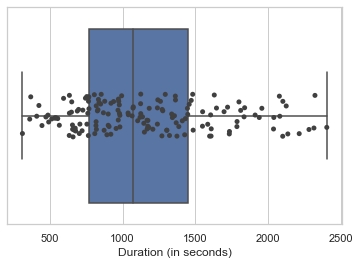

Mean of time: 19.245 min.


In [9]:
time_sub_clean = time_sub.copy()

time_sub_clean = time_sub_clean[~time_sub_clean.index.isin(time_toolong_index)]

sns.set(style='whitegrid')
palette = sns.color_palette('deep')

sns.boxplot(data=time_sub_clean,x='Duration (in seconds)',color=palette[0])
sns.stripplot(data=time_sub_clean,x='Duration (in seconds)',color='.25')
time_mean = time_sub_clean['Duration (in seconds)'].mean()
time_std = time_sub_clean['Duration (in seconds)'].std()
plt.show()
print(f'Mean of time: {round(time_mean/60,3)} min.')
#print(f'Std of time: {time_std}')

## Check size 

In [11]:
check_size_files = [file for file in qualtrics_files if 'D2' in file]
check_size_df = pd.DataFrame()
for file in check_size_files:
    df = pd.read_csv('remove_name/'+file,encoding='gb18030')
    df = df.iloc[2:,:]
    df['Q40.2'] = df['Q40.2'].astype(int)
    df.index = df['Q40.2']
    check_size_items = [item for item in df.columns if item.startswith('Q41')]
    temp_df = df[check_size_items]
    temp_df.columns = ['Ant','Coin','Elephant','Plane','Rabbit']
    temp_df = temp_df.apply(pd.to_numeric)
    check_size_df = pd.concat([check_size_df,temp_df])

check_size_outlier = []
check_size_df_clean = check_size_df.copy()
# reponse more than or less than 3.5 std
for item in ['Ant','Coin','Elephant','Plane','Rabbit']:
    item_df = check_size_df_clean[item]
    mean = item_df.mean()
    std = item_df.std()
    outlier_index = item_df.index[(item_df > mean+3.5*std) | (item_df < mean-3.5*std)].to_list()
    check_size_outlier.append(outlier_index)
    
check_size_outlier = [sub for sublist in check_size_outlier for sub in \
        (sublist if isinstance(sublist, list) else [sublist])]#expand the nested list into a list
check_size_outlier = list(set(check_size_outlier))#delete duplicate participants
check_size_df_clean = check_size_df_clean[~check_size_df_clean.index.isin(check_size_outlier)]
check_size_outlier

[16, 18, 48, 14]

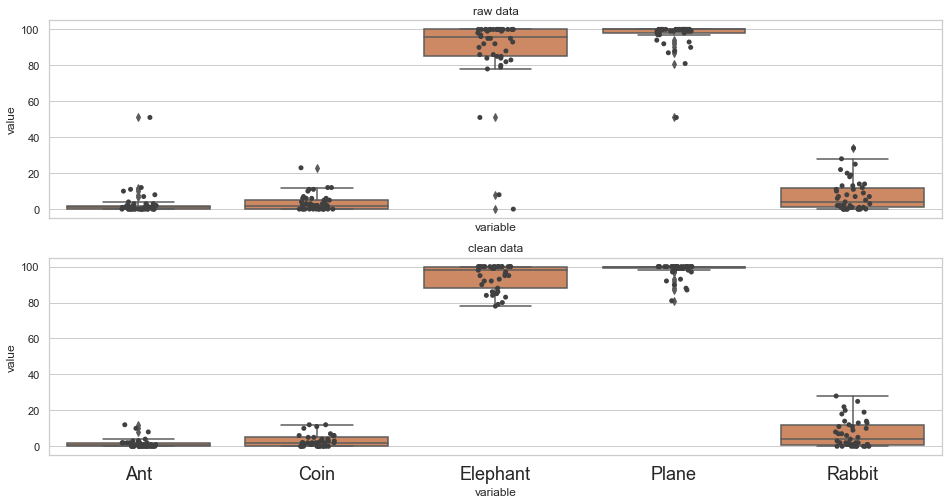

In [12]:
check_size_df_melt = pd.melt(check_size_df)
check_size_df_clean_melt = pd.melt(check_size_df_clean)

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8),sharex=True)
palette = sns.color_palette('deep')
sns.boxplot(data=check_size_df_melt,x='variable',y='value',color=palette[1],ax=axes[0])
sns.stripplot(data=check_size_df_melt,x='variable',y='value',color='.25',ax=axes[0])
axes[0].set_title("raw data")

sns.boxplot(data=check_size_df_clean_melt,x='variable',y='value',color=palette[1],ax=axes[1])
sns.stripplot(data=check_size_df_clean_melt,x='variable',y='value',color='.25',ax=axes[1])
axes[1].set_title("clean data")

plt.xticks(fontsize=18)
plt.show()

In [13]:
check_size_df[check_size_df.index.isin(check_size_outlier)]

,Ant,Coin,Elephant,Plane,Rabbit
Q40.2,,,,,
48,0,0,0,100,0
16,51,0,51,51,0
18,11,23,82,94,34
14,7,11,8,100,7


Confirmation was sought from the participant again, and due to an accidental touch, the actual selection for the check size question by *participant 48 was 80, participant 14 was 100*.

# Organize data

- GX: sequence of relationships    
- DX: order of dimensions    
- Data store dictionary:
    - key: dimension  
    - value: response from participants in the same group, with each participant represented by a unique number code

Store the dimension relationships of different versions in the dictionary.

In [14]:
dim_item_dict = {}
rel_dict = {}

dims_4D = pd.read_excel('pre_file/version_subinfo.xlsx',sheet_name='dimension_4_versions')
for v in range(1,5):
    dim_item = {}
    dims = dims_4D.loc[dims_4D.Version==v,:].iloc[:,2].to_list()
    items = dims_4D.loc[dims_4D.Version==v,:].iloc[:,0].to_list()
    dim_item['dim'] = dims
    dim_item['item'] = items
    dim_item_dict['D'+str(v)] = dim_item

rels_5G = pd.read_excel('pre_file/version_subinfo.xlsx',sheet_name='group_5_versions')
rels_130 = rels_5G.Relationship.to_list()
for v in range(1,6):
    rels = rels_5G.loc[rels_5G.Version==v,'Relationship'].to_list()
    rel_dict['G'+str(v)] = rels

In [16]:
rating_dim_rel = {}

for file in qualtrics_files:
    path = 'remove_name/' + file
    df = pd.read_csv(path, encoding='gb18030')
    df = df.iloc[2:,:]
    # One of the participants entered the wrong identification number
    if file.startswith('G4D3'):
        df.loc[df['Random ID']=='58427','Q40.2'] = 30
        
    df['Q40.2'] = df['Q40.2'].astype(int)
    df.index = df['Q40.2']    
    #######################
    day = file[2:4]
    group = file[0:2]
    dims = dim_item_dict[day]['dim']
    rels = rel_dict[group]
    
    items_dims = dim_item_dict[day]['item']
    # 1.rating 26 relationship in 8 or 9 dimensions
    for (i,num) in enumerate(items_dims):
        items = [item for item in df.columns if item.startswith('Q'+str(int(num))+'.4')]
        rating_df = df[items]
        rating_df.columns = rels
        rating_df = rating_df.apply(pd.to_numeric)
        if dims[i] in rating_dim_rel:
            rating_dim_rel[dims[i]][group] = rating_df 
        else:
            rating_dim_rel[dims[i]] = {group:rating_df}

In [17]:
rating_dim_rel_clean = copy.deepcopy(rating_dim_rel)
for dim in rating_dim_rel.keys():
    dim_dict = rating_dim_rel_clean[dim]
    for group in dim_dict.keys():
        rating_all_df = dim_dict[group]
        rating_clean_df = rating_all_df[~rating_all_df.index.isin([3])] # exclude the unqualified subject
        dim_dict[group] = rating_clean_df.to_json(orient='split') # transform dataframe into json; to store dataframe into a dictionary
    rating_dim_rel_clean[dim] = dim_dict

In [18]:
json_str = json.dumps(rating_dim_rel_clean, indent=4)
with open('output_data/dict_results/dict_clean.json', 'w') as f:
    f.write(json_str)

# Dimension×Relationship matrix

In [19]:
# import dictionary results
with open('output_data/dict_results/dict_clean.json', 'r') as file:
    clean_dict = json.load(file)
    
rating_dim_rel_clean = dict()
for dim in clean_dict.keys():
    dim_dict = clean_dict[dim]
    for group in dim_dict.keys():
        rating_df = dim_dict[group]
        rating_df = pd.read_json(rating_df, orient='split')
        dim_dict[group] = rating_df
    rating_dim_rel_clean[dim] = dim_dict
    
# store cell results in dataframe with the form of list    
dim_rel_clean_cell = pd.DataFrame(index = rels_130,columns = rating_dim_rel_clean.keys())
for dim in dim_rel_clean_cell.columns:
    rating_group = rating_dim_rel[dim]
    for group in rating_group.keys():
        temp_df =  rating_group[group]
        for rel in temp_df.columns:
            rating_list = temp_df.loc[:,rel].to_list()
            dim_rel_clean_cell.loc[rel,dim] = rating_list
dim_rel_clean_cell.to_csv('output_data/dict_results/dim_rel_clean_cell.csv',encoding='gb18030')

In [20]:
dim_rel_df = pd.DataFrame(index = rels_130,columns = rating_dim_rel.keys())
for dim in dim_rel_df.columns:
    rating_group = rating_dim_rel[dim]
    for group in rating_group.keys():
        temp_df =  rating_group[group]
        temp_df = temp_df[~temp_df.index.isin([3])]
        dim_rel_df.loc[temp_df.columns,dim] = temp_df.mean()
dim_rel_df = dim_rel_df.apply(pd.to_numeric)

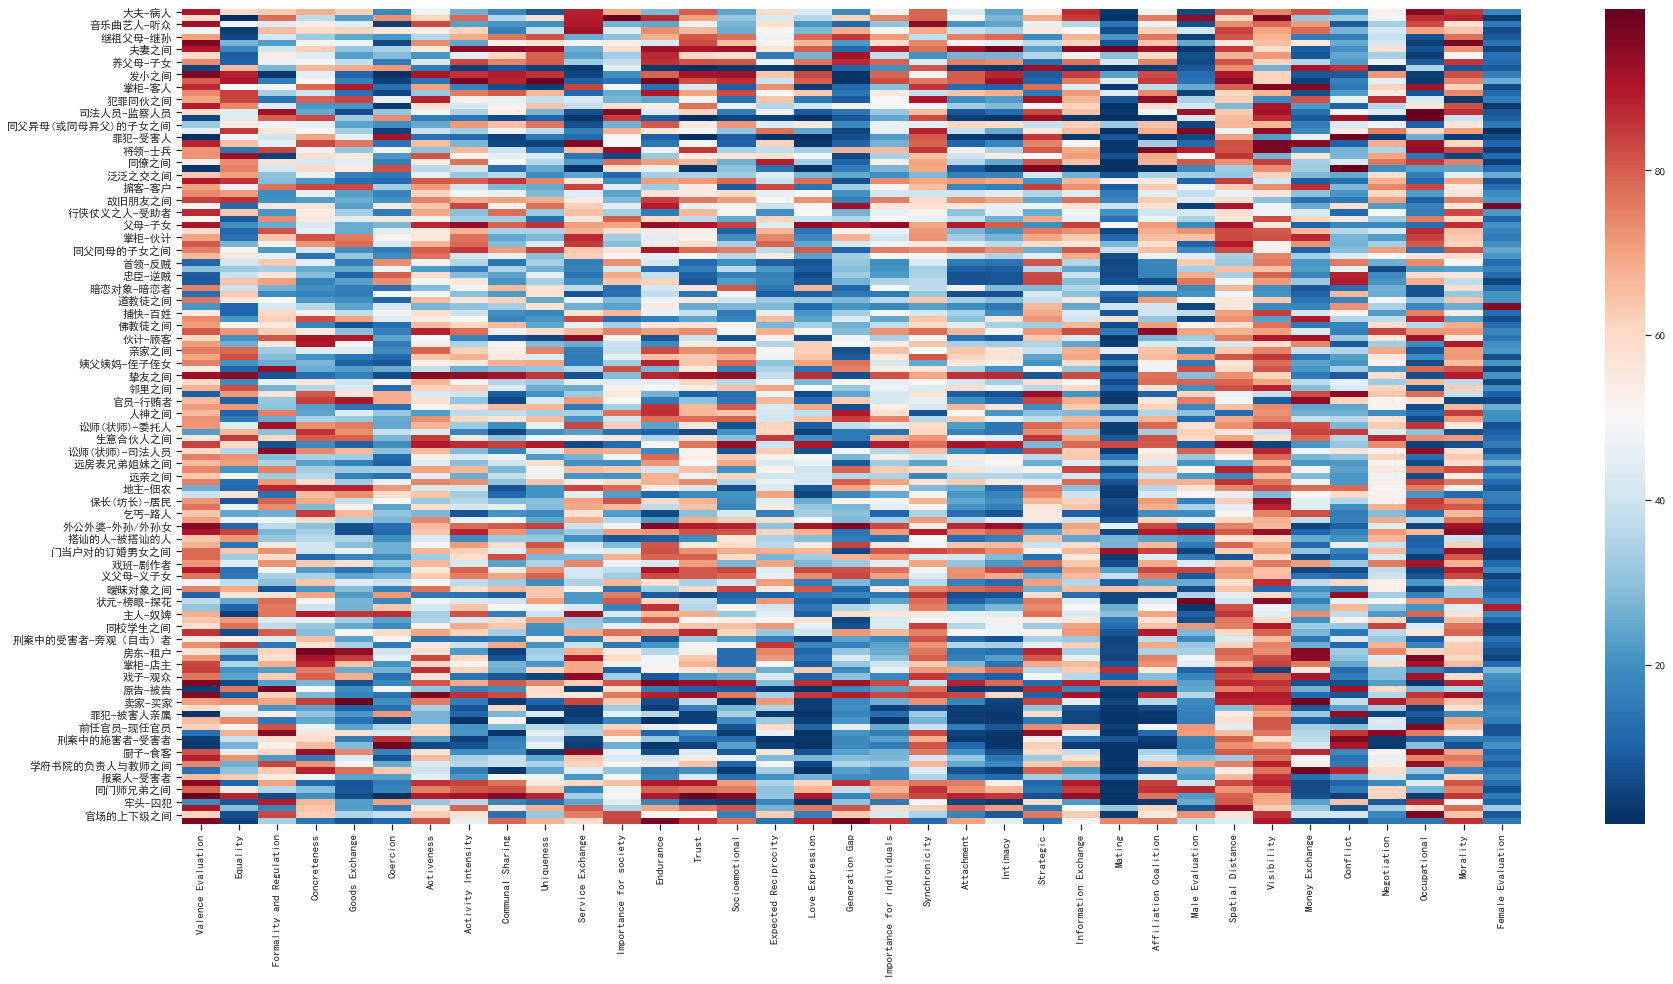

In [21]:
plt.figure(figsize=(30,15))
rc = {'font.sans-serif': 'SimHei','axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)
sns.heatmap(dim_rel_df,center=50,cmap='RdBu_r')
dim_rel_df.to_csv('output_data/clean_results/dim_rel_df.csv',encoding='gb18030')

dim_rel_scaled = preprocessing.scale(dim_rel_df)
dim_rel_scaled = pd.DataFrame(dim_rel_scaled,
                              index=dim_rel_df.index,columns=dim_rel_df.columns)
dim_rel_scaled.to_csv('output_data/clean_results/dim_rel_scaled.csv',encoding='gb18030')

# The last item and demographics

In [22]:
last_item_files = os.listdir('remove_name/')
last_item_files = [file for file in last_item_files if 'D4' in file]

androcentrism_df = pd.DataFrame()
for file in last_item_files:
    input_path = 'remove_name/'+file
    temp_df = pd.read_csv(input_path, index_col=0, encoding='gb18030')
    temp_df = temp_df[['Q42','Q40.2']]
    temp_df = temp_df.iloc[2:,:]
    temp_df = temp_df.reset_index(drop=True)
    temp_df.columns = ['人的性别','被试编号']
    
    androcentrism_df = pd.concat([androcentrism_df,temp_df],axis=0)
#The participant did not fill it out in the questionnaire and reported it later through WeChat.
androcentrism_df['被试编号'] = androcentrism_df['被试编号'].apply(pd.to_numeric)
androcentrism_df.loc[androcentrism_df['被试编号']==5,'人的性别'] = '男性' 

In [23]:
demo = pd.read_csv('pre_file/subinfo_dynasty.csv',encoding = 'gb18030',index_col=0)
demo = demo.loc[2:,['Q1.1','Q3','Q4','Q5','Q8','Q13','Q14','Q15','Dynasty','Group']]
demo.columns = ['被试编号','年龄','性别','民族','教育水平','成长环境','所在地区','中文是母语','Dynasty','Group']

In [24]:
androcentrism_demo = pd.merge(androcentrism_df,demo,on='被试编号', how='outer')
androcentrism_demo = androcentrism_demo.dropna(how='any')
androcentrism_demo = androcentrism_demo.loc[~androcentrism_demo['被试编号'].isin([3]),:]
androcentrism_demo.to_csv('output_data/androcentrism_demo.csv',encoding='gb18030')
androcentrism_demo.shape

(44, 11)

In [25]:
demo_report = copy.deepcopy(androcentrism_demo)
# 1.transform age
demo_report['年龄'] = demo_report['年龄'].astype(int)
age_conditions = [
    (demo_report['年龄'] >= 18) & (demo_report['年龄'] <= 24),
    (demo_report['年龄'] >= 25) & (demo_report['年龄'] <= 34)
]
age_labels = ['18-24', '25-34']

demo_report['age'] = pd.np.select(age_conditions, age_labels, default = None)

# 2.transform education level
edu_conditions = [
    (demo_report['教育水平'].str.contains('博')),
    (demo_report['教育水平'].str.contains('硕')),
    (demo_report['教育水平'].str.contains('本科'))
]
edu_labels = ['博士','硕士','本科']
demo_report['education'] = pd.np.select(edu_conditions,edu_labels, default =None)

In [26]:
demo_report

,人的性别,被试编号,年龄,性别,民族,教育水平,成长环境,所在地区,中文是母语,Dynasty,Group,age,education
0,男性,12.0,23,女,汉族,2022级硕士,城市,北京市,是,元明清,G1,18-24,硕士
1,男性,22.0,22,女,汉族,2023级硕士,城市,江苏省,是,唐宋,G1,18-24,硕士
2,男性,32.0,23,女,汉族,2022硕士,城市,山东省,是,春秋战国（先秦）,G1,18-24,硕士
3,男性,38.0,30,男,汉族,2014级硕士,农村,山东省,是,春秋战国（先秦）,G1,25-34,硕士
4,男性,25.0,25,女,汉族,2021级硕士,城市,北京市,是,唐宋,G1,25-34,硕士
5,男性,34.0,25,女,汉族,2020硕士,城市,广东省,是,春秋战国（先秦）,G1,25-34,硕士
6,女性,26.0,29,男,汉族,2022级博士,农村,湖南省,是,元明清,G1,25-34,博士
7,男性,46.0,23,女,汉族,2022级硕士,城市,河北省,是,唐宋,G1,18-24,硕士
8,男性,48.0,26,女,汉族,2022级硕士,农村,内蒙古自治区,是,秦汉,G1,25-34,硕士
9,男性,42.0,21,女,汉族,2020级本科,城市,广东省,是,元明清,G2,18-24,本科


In [27]:
Counter(demo_report['age'])

Counter({'18-24': 25, '25-34': 19})

In [28]:
Counter(demo_report['性别'])

Counter({'女': 36, '男': 8})

In [29]:
Counter(demo_report['education'])

Counter({'硕士': 28, '博士': 14, '本科': 2})

In [30]:
Counter(demo_report['民族'])

Counter({'汉族': 44})